# Yelp data analysis

In [2]:
import pandas as pd
import sys

In [3]:
# Import helper functions
from scripts import data_extraction as d_extract
from scripts import data_filtering as d_filter
from scripts import feature_engineering as f_eng
from scripts import visualization as viz

## Yelp Dataset EDA


###  Businesses dataset

In [6]:
# Count of the total number of JSON records (businesses)

total_businesses = d_extract.count_records('../data/raw/yelp_academic_dataset_business.json')

Counted 100,000 records so far...

Total records: 150,346


In [8]:
# Load all businesses
df_business = d_extract.extract_all_businesses('../data/raw/yelp_academic_dataset_business.json')

Processed 50,000 businesses...
Processed 100,000 businesses...
Processed 150,000 businesses...

Total businesses loaded: 150,346


In [3]:
def extract_all_businesses(filename):
    """Extract all business data for later use"""
    businesses = []
    
    with open(filename, 'r') as f:
        for i, line in enumerate(f):
            biz = json.loads(line)
            businesses.append({
                'business_id': biz['business_id'],
                'name': biz['name'],
                'city': biz.get('city'),
                'state': biz.get('state'),
                'postal_code': biz.get('postal_code'),
                'latitude': biz.get('latitude'),
                'longitude': biz.get('longitude'),
                'stars': biz.get('stars'),
                'review_count': biz.get('review_count'),
                'is_open': biz.get('is_open'),
                'categories': biz.get('categories', '')
            })
            
            if (i + 1) % 50000 == 0:
                print(f"Processed {i + 1} businesses...")
    
    df = pd.DataFrame(businesses)
    print(f"\nTotal businesses loaded: {len(df):,}")
    
    # Save to CSV for easy reuse
    df.to_csv('all_businesses.csv', index=False)
    print("Saved to 'all_businesses.csv'")
    
    return df

# Run it
df_business = extract_all_businesses('../data/raw/yelp_academic_dataset_business.json')

# Quick analysis
print(f"Unique cities: {df_business['city'].nunique()}")
print(f"Unique states: {df_business['state'].nunique()}")
print("\nTop 20 cities by business count:")
print(df_business['city'].value_counts().head(20))

Processed 50000 businesses...
Processed 100000 businesses...
Processed 150000 businesses...

Total businesses loaded: 150,346
Saved to 'all_businesses.csv'
Unique cities: 1416
Unique states: 27

Top 20 cities by business count:
city
Philadelphia        14569
Tucson               9250
Tampa                9050
Indianapolis         7540
Nashville            6971
New Orleans          6209
Reno                 5935
Edmonton             5054
Saint Louis          4827
Santa Barbara        3829
Boise                2937
Clearwater           2221
Saint Petersburg     1663
Metairie             1643
Sparks               1624
Wilmington           1446
Franklin             1414
St. Louis            1255
St. Petersburg       1185
Meridian             1043
Name: count, dtype: int64


### What categories exist in the dataset?

In [4]:
from collections import Counter

# Load your business data
df_business = pd.read_csv('all_businesses.csv')

# Extract all unique categories
all_categories = []

for categories_str in df_business['categories'].dropna():
    # Split by comma (categories are stored as "Mexican, Burgers, Gastropubs")
    categories = [cat.strip() for cat in str(categories_str).split(',')]
    all_categories.extend(categories)

# Count them
category_counts = Counter(all_categories)

print(f"Total unique categories: {len(category_counts)}")
print("\nTop 20 most common categories:")
for i, (category, count) in enumerate(category_counts.most_common(20), 1):
    print(f"{i:2d}. {category:40s} {count:6,} businesses")

# Save for reference
category_df = pd.DataFrame(category_counts.most_common(), 
                          columns=['category', 'business_count'])
category_df.to_csv('all_categories.csv', index=False)

Total unique categories: 1311

Top 20 most common categories:
 1. Restaurants                              52,268 businesses
 2. Food                                     27,781 businesses
 3. Shopping                                 24,395 businesses
 4. Home Services                            14,356 businesses
 5. Beauty & Spas                            14,292 businesses
 6. Nightlife                                12,281 businesses
 7. Health & Medical                         11,890 businesses
 8. Local Services                           11,198 businesses
 9. Bars                                     11,065 businesses
10. Automotive                               10,773 businesses
11. Event Planning & Services                 9,895 businesses
12. Sandwiches                                8,366 businesses
13. American (Traditional)                    8,139 businesses
14. Active Life                               7,687 businesses
15. Pizza                                     7,093 busi

In [5]:

def filter_by_city_and_category(df, city, state, category):
    """
    Filter businesses by city, state, and category
    
    Parameters:
    - df: DataFrame with business data
    - city: city name (e.g., 'Philadelphia')
    - state: state code (e.g., 'PA')
    - category: category to search for (e.g., 'Restaurants')
    
    Returns:
    - Filtered DataFrame
    """
    # Filter by city and state
    df_city = df[(df['city'] == city) & (df['state'] == state)].copy()
    
    # Filter by category
    def has_category(categories_str):
        if pd.isna(categories_str):
            return False
        # Split and check if target category is in the list
        cats = [cat.strip() for cat in str(categories_str).split(',')]
        return category in cats
    
    df_filtered = df_city[df_city['categories'].apply(has_category)].copy()
    
    return df_filtered

# Use the function for Philadelphia
print("="*70)
print("PHILADELPHIA RESTAURANTS")
print("="*70)
df_philly_restaurants = filter_by_city_and_category(
    df_business, 
    'Philadelphia', 
    'PA', 
    'Restaurants'
)
print(f"Found: {len(df_philly_restaurants)} businesses")
print(f"Total reviews: {df_philly_restaurants['review_count'].sum():,}")
print("\nSample:")
print(df_philly_restaurants[['name', 'stars', 'review_count']].head(10))

print("\n" + "="*70)
print("PHILADELPHIA HOTELS & TRAVEL")
print("="*70)
df_philly_hotels = filter_by_city_and_category(
    df_business, 
    'Philadelphia', 
    'PA', 
    'Hotels & Travel'
)
print(f"Found: {len(df_philly_hotels)} businesses")
print(f"Total reviews: {df_philly_hotels['review_count'].sum():,}")
print("\nSample:")
print(df_philly_hotels[['name', 'stars', 'review_count']].head(10))

# Combined summary
print("\n" + "="*70)
print("SUMMARY")
print("="*70)
print(f"Restaurants: {len(df_philly_restaurants)} businesses")
print(f"Hotels & Travel: {len(df_philly_hotels)} businesses")
print(f"Total: {len(df_philly_restaurants) + len(df_philly_hotels)} businesses")

PHILADELPHIA RESTAURANTS
Found: 5852 businesses
Total reviews: 665,732

Sample:
                                    name  stars  review_count
3                     St Honore Pastries    4.0            80
15                              Tuna Bar    4.0           245
19                                   BAP    4.5           205
28                               Bar One    4.0            65
31                      DeSandro on Main    3.0            41
35                            Craft Hall    3.5            65
82                                  Wawa    3.0            56
130  Golden Chopstick Chinese Restaurant    3.0           137
151                              J Sushi    4.5            72
199                              Wendy's    1.5            15

PHILADELPHIA HOTELS & TRAVEL
Found: 392 businesses
Total reviews: 28,982

Sample:
                                   name  stars  review_count
143              David Thomas Trailways    4.5             6
246   Watson Adventures Scavenger

In [6]:
# Use the same function for New Orleans
print("="*70)
print("NEW ORLEANS RESTAURANTS")
print("="*70)
df_nola_restaurants = filter_by_city_and_category(
    df_business, 
    'New Orleans', 
    'LA', 
    'Restaurants'
)
print(f"Found: {len(df_nola_restaurants)} businesses")
print(f"Total reviews: {df_nola_restaurants['review_count'].sum():,}")
print("\nSample:")
print(df_nola_restaurants[['name', 'stars', 'review_count']].head(10))

print("\n" + "="*70)
print("NEW ORLEANS HOTELS & TRAVEL")
print("="*70)
df_nola_hotels = filter_by_city_and_category(
    df_business, 
    'New Orleans', 
    'LA', 
    'Hotels & Travel'
)
print(f"Found: {len(df_nola_hotels)} businesses")
print(f"Total reviews: {df_nola_hotels['review_count'].sum():,}")
print("\nSample:")
print(df_nola_hotels[['name', 'stars', 'review_count']].head(10))

# Combined summary
print("\n" + "="*70)
print("SUMMARY")
print("="*70)
print(f"Restaurants: {len(df_nola_restaurants)} businesses")
print(f"Hotels & Travel: {len(df_nola_hotels)} businesses")
print(f"Total: {len(df_nola_restaurants) + len(df_nola_hotels)} businesses")
print(f"\n✓ Meets minimum 8-10 businesses requirement? {len(df_nola_restaurants) + len(df_nola_hotels) >= 10}")

NEW ORLEANS RESTAURANTS
Found: 2259 businesses
Total reviews: 465,982

Sample:
                            name  stars  review_count
87                   Copper Vine    4.5           350
103   Mahony's Po-Boys & Seafood    4.0           382
131                     Altamura    3.5            27
231  Eat Mah Taco @ Pal's Lounge    4.5             8
253              Mellow Mushroom    3.5           149
278               Las Margaritas    3.5            58
282  Olivier's Creole Restaurant    3.5           172
333              Saltwater Grill    2.5            34
352                  Blaze Pizza    4.0           302
476                 Garage Pizza    4.0             6

NEW ORLEANS HOTELS & TRAVEL
Found: 620 businesses
Total reviews: 59,741

Sample:
                                      name  stars  review_count
34                               River 127    3.0            12
65                New Orleans Spirit Tours    4.0            38
155                      Rathbone Mansions    3.5    

Extracting reviews for New Orleans...
  Restaurants to check: 2259
  Hotels to check: 620
  Processed 500,000 reviews... (Found 40,266 restaurant + 7,027 hotel reviews)
  Processed 1,000,000 reviews... (Found 72,511 restaurant + 11,671 hotel reviews)
  Processed 1,500,000 reviews... (Found 98,843 restaurant + 14,987 hotel reviews)
  Processed 2,000,000 reviews... (Found 134,424 restaurant + 17,189 hotel reviews)
  Processed 2,500,000 reviews... (Found 170,580 restaurant + 20,272 hotel reviews)
  Processed 3,000,000 reviews... (Found 202,044 restaurant + 23,886 hotel reviews)
  Processed 3,500,000 reviews... (Found 232,662 restaurant + 27,791 hotel reviews)
  Processed 4,000,000 reviews... (Found 270,289 restaurant + 31,431 hotel reviews)
  Processed 4,500,000 reviews... (Found 308,859 restaurant + 35,963 hotel reviews)
  Processed 5,000,000 reviews... (Found 345,407 restaurant + 40,774 hotel reviews)
  Processed 5,500,000 reviews... (Found 384,338 restaurant + 47,297 hotel reviews)
  P

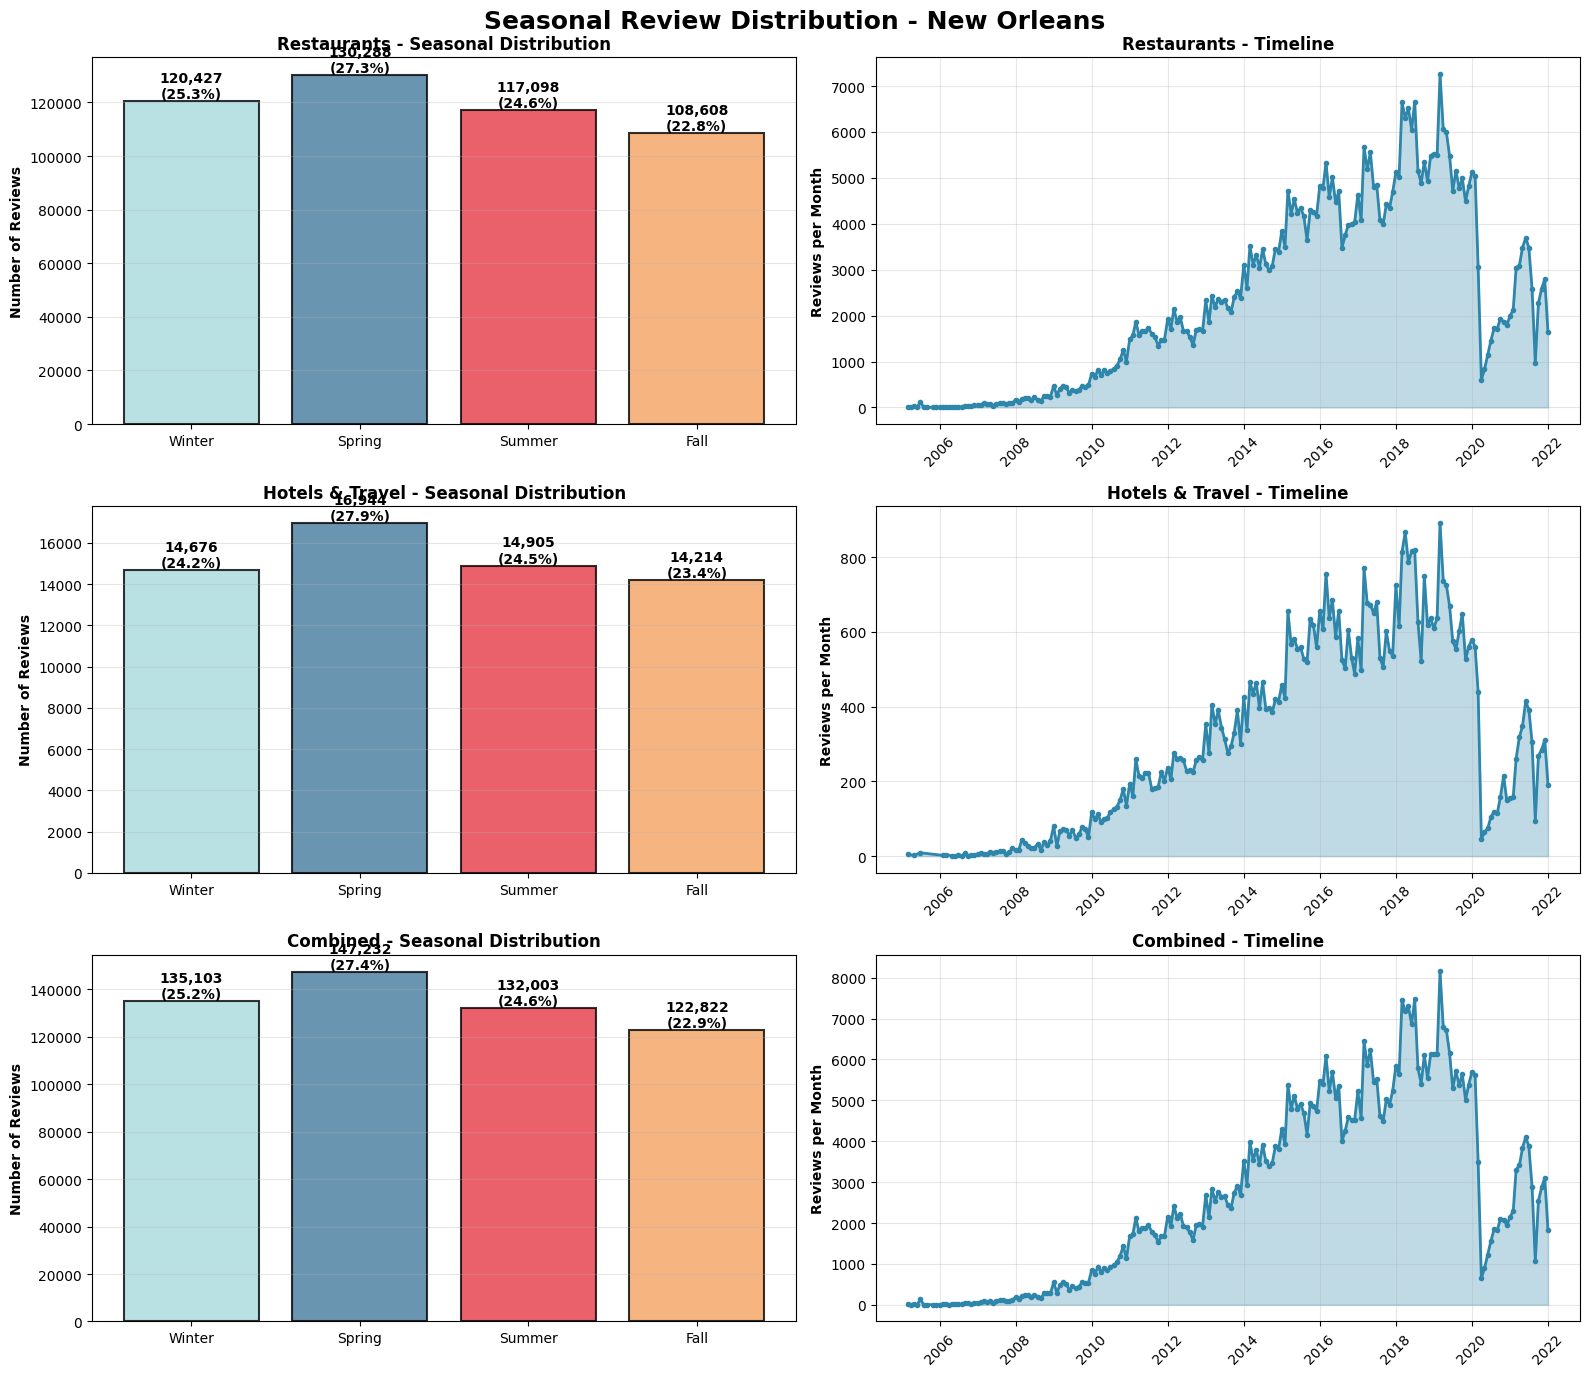


SEASONAL DISTRIBUTION ANALYSIS

RESTAURANTS
--------------------------------------------------------------------------------
  Winter  : 120,427 reviews ( 25.3%)
  Spring  : 130,288 reviews ( 27.3%)
  Summer  : 117,098 reviews ( 24.6%)
  Fall    : 108,608 reviews ( 22.8%)

  Total: 476,421 reviews
  Date range: 2005-03-14 to 2022-01-19
  Weakest season: Fall (22.8%)
  ✓ BALANCED: All seasons ≥15%

HOTELS & TRAVEL
--------------------------------------------------------------------------------
  Winter  : 14,676 reviews ( 24.2%)
  Spring  : 16,944 reviews ( 27.9%)
  Summer  : 14,905 reviews ( 24.5%)
  Fall    : 14,214 reviews ( 23.4%)

  Total: 60,739 reviews
  Date range: 2005-03-15 to 2022-01-19
  Weakest season: Fall (23.4%)
  ✓ BALANCED: All seasons ≥15%

COMBINED
--------------------------------------------------------------------------------
  Winter  : 135,103 reviews ( 25.2%)
  Spring  : 147,232 reviews ( 27.4%)
  Summer  : 132,003 reviews ( 24.6%)
  Fall    : 122,822 reviews (

In [7]:
import matplotlib.pyplot as plt
from datetime import datetime

def analyze_seasonal_distribution(review_file, business_ids_restaurants, business_ids_hotels, city_name):
    """
    Analyze review distribution by season for restaurants and hotels
    Only reads the REVIEW JSON file (business data already in CSV)
    """
    
    restaurants_reviews = []
    hotels_reviews = []
    
    print(f"Extracting reviews for {city_name}...")
    print(f"  Restaurants to check: {len(business_ids_restaurants)}")
    print(f"  Hotels to check: {len(business_ids_hotels)}")
    
    with open(review_file, 'r') as f:
        for i, line in enumerate(f):
            review = json.loads(line)
            business_id = review['business_id']
            
            if business_id in business_ids_restaurants:
                restaurants_reviews.append({
                    'date': review['date'],
                    'stars': review['stars'],
                    'category': 'Restaurants'
                })
            
            if business_id in business_ids_hotels:
                hotels_reviews.append({
                    'date': review['date'],
                    'stars': review['stars'],
                    'category': 'Hotels & Travel'
                })
            
            if (i + 1) % 500000 == 0:
                print(f"  Processed {i + 1:,} reviews... (Found {len(restaurants_reviews):,} restaurant + {len(hotels_reviews):,} hotel reviews)")
    
    # Combine into DataFrames
    df_restaurants = pd.DataFrame(restaurants_reviews)
    df_hotels = pd.DataFrame(hotels_reviews)
    df_combined = pd.concat([df_restaurants, df_hotels], ignore_index=True)
    
    print(f"\n✓ Found {len(df_restaurants):,} restaurant reviews")
    print(f"✓ Found {len(df_hotels):,} hotel reviews")
    print(f"✓ Total: {len(df_combined):,} reviews")
    
    # Convert dates
    for df in [df_restaurants, df_hotels, df_combined]:
        if len(df) > 0:
            df['date'] = pd.to_datetime(df['date'])
            df['month'] = df['date'].dt.month
            df['year'] = df['date'].dt.year
            df['year_month'] = df['date'].dt.to_period('M')
    
    return df_restaurants, df_hotels, df_combined


def visualize_seasonal_distribution(df_restaurants, df_hotels, df_combined, city_name):
    """
    Create three visualizations: restaurants, hotels, and combined
    """
    
    def get_season(month):
        if month in [12, 1, 2]:
            return 'Winter'
        elif month in [3, 4, 5]:
            return 'Spring'
        elif month in [6, 7, 8]:
            return 'Summer'
        else:
            return 'Fall'
    
    # Add season column
    for df in [df_restaurants, df_hotels, df_combined]:
        if len(df) > 0:
            df['season'] = df['month'].apply(get_season)
    
    # Create figure with 3x2 grid
    fig, axes = plt.subplots(3, 2, figsize=(16, 14))
    fig.suptitle(f'Seasonal Review Distribution - {city_name}', fontsize=18, fontweight='bold')
    
    season_order = ['Winter', 'Spring', 'Summer', 'Fall']
    colors = ['#A8DADC', '#457B9D', '#E63946', '#F4A261']
    
    datasets = [
        (df_restaurants, 'Restaurants', 0),
        (df_hotels, 'Hotels & Travel', 1),
        (df_combined, 'Combined', 2)
    ]
    
    for df, label, row in datasets:
        if len(df) == 0:
            axes[row, 0].text(0.5, 0.5, f'No {label} data', 
                            ha='center', va='center', fontsize=14)
            axes[row, 1].text(0.5, 0.5, f'No {label} data', 
                            ha='center', va='center', fontsize=14)
            continue
        
        # Left column: Seasonal bar chart
        season_counts = df['season'].value_counts()[season_order]
        total = season_counts.sum()
        
        bars = axes[row, 0].bar(season_counts.index, season_counts.values, 
                                color=colors, alpha=0.8, edgecolor='black', linewidth=1.5)
        axes[row, 0].set_title(f'{label} - Seasonal Distribution', fontweight='bold', fontsize=12)
        axes[row, 0].set_ylabel('Number of Reviews', fontweight='bold')
        axes[row, 0].grid(True, alpha=0.3, axis='y')
        
        # Add percentage labels on bars
        for i, (season, count) in enumerate(season_counts.items()):
            pct = (count / total) * 100
            axes[row, 0].text(i, count, f'{count:,}\n({pct:.1f}%)', 
                            ha='center', va='bottom', fontweight='bold', fontsize=10)
        
        # Right column: Timeline
        monthly_counts = df.groupby('year_month').size()
        monthly_counts.index = monthly_counts.index.to_timestamp()
        
        axes[row, 1].plot(monthly_counts.index, monthly_counts.values, 
                         linewidth=2, color='#2E86AB', marker='o', markersize=3)
        axes[row, 1].fill_between(monthly_counts.index, monthly_counts.values, 
                                  alpha=0.3, color='#2E86AB')
        axes[row, 1].set_title(f'{label} - Timeline', fontweight='bold', fontsize=12)
        axes[row, 1].set_ylabel('Reviews per Month', fontweight='bold')
        axes[row, 1].grid(True, alpha=0.3)
        axes[row, 1].tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    plt.savefig(f'{city_name.replace(" ", "_")}_seasonal_analysis.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Print statistics
    print("\n" + "="*80)
    print("SEASONAL DISTRIBUTION ANALYSIS")
    print("="*80)
    
    for df, label in [(df_restaurants, 'RESTAURANTS'), 
                      (df_hotels, 'HOTELS & TRAVEL'), 
                      (df_combined, 'COMBINED')]:
        if len(df) == 0:
            continue
            
        print(f"\n{label}")
        print("-" * 80)
        
        season_counts = df['season'].value_counts()[season_order]
        total = season_counts.sum()
        
        for season in season_order:
            count = season_counts[season]
            pct = (count / total) * 100
            print(f"  {season:8s}: {count:6,} reviews ({pct:5.1f}%)")
        
        min_season = season_counts.idxmin()
        min_count = season_counts.min()
        min_pct = (min_count / total) * 100
        
        print(f"\n  Total: {total:,} reviews")
        print(f"  Date range: {df['date'].min().date()} to {df['date'].max().date()}")
        print(f"  Weakest season: {min_season} ({min_pct:.1f}%)")
        
        if min_pct >= 15:
            print(f"  ✓ BALANCED: All seasons ≥15%")
        else:
            print(f"  ✗ IMBALANCED: Weakest season <15%")


# Execute for New Orleans using the DataFrames we already have
business_ids_restaurants = set(df_nola_restaurants['business_id'])
business_ids_hotels = set(df_nola_hotels['business_id'])

# Extract reviews (this is the only part that reads JSON)
df_rest, df_hotels, df_comb = analyze_seasonal_distribution(
    '../data/raw/yelp_academic_dataset_review.json',
    business_ids_restaurants,
    business_ids_hotels,
    'New Orleans'
)

# Create visualizations
visualize_seasonal_distribution(df_rest, df_hotels, df_comb, 'New Orleans')

In [8]:
def check_dataset_date_range(review_file):
    """Check the overall date range of the entire review dataset"""
    
    min_date = None
    max_date = None
    total_reviews = 0
    
    print("Scanning entire review dataset for date range...")
    print("(This will take a few minutes)")
    
    with open(review_file, 'r') as f:
        for i, line in enumerate(f):
            review = json.loads(line)
            date = review['date']
            
            if min_date is None or date < min_date:
                min_date = date
            if max_date is None or date > max_date:
                max_date = date
            
            total_reviews += 1
            
            if (i + 1) % 1000000 == 0:
                print(f"  Processed {i + 1:,} reviews... (Current range: {min_date} to {max_date})")
    
    print("\n" + "="*70)
    print("ENTIRE YELP DATASET DATE RANGE")
    print("="*70)
    print(f"Earliest review: {min_date}")
    print(f"Latest review:   {max_date}")
    print(f"Total reviews:   {total_reviews:,}")
    print("="*70)

# Run it
check_dataset_date_range('../data/raw/yelp_academic_dataset_review.json')

Scanning entire review dataset for date range...
(This will take a few minutes)
  Processed 1,000,000 reviews... (Current range: 2005-03-01 17:47:15 to 2022-01-19 19:47:59)
  Processed 2,000,000 reviews... (Current range: 2005-03-01 16:57:17 to 2022-01-19 19:47:59)
  Processed 3,000,000 reviews... (Current range: 2005-03-01 16:57:17 to 2022-01-19 19:48:16)
  Processed 4,000,000 reviews... (Current range: 2005-03-01 16:57:17 to 2022-01-19 19:48:16)
  Processed 5,000,000 reviews... (Current range: 2005-02-16 03:23:22 to 2022-01-19 19:48:45)
  Processed 6,000,000 reviews... (Current range: 2005-02-16 03:23:22 to 2022-01-19 19:48:45)

ENTIRE YELP DATASET DATE RANGE
Earliest review: 2005-02-16 03:23:22
Latest review:   2022-01-19 19:48:45
Total reviews:   6,990,280


### Retrieveing data for NOL - 2013, 2016, 2018

In [9]:
import json
import pandas as pd

def extract_nola_dataset(business_df_restaurants, business_df_hotels, 
                         review_file, user_file, 
                         target_years=[2013, 2016, 2018],
                         city='New Orleans', state='LA'):
    """
    Extract complete dataset for New Orleans for specified years
    """
    
    # Combine restaurant and hotel businesses
    business_df = pd.concat([business_df_restaurants, business_df_hotels], ignore_index=True)
    business_ids = set(business_df['business_id'])
    
    print(f"Extracting data for {city}, {state}")
    print(f"Target years: {target_years}")
    print(f"Businesses to track: {len(business_ids)}")
    
    # Step 1: Extract reviews for target years
    print("\n" + "="*80)
    print("STEP 1: Extracting Reviews")
    print("="*80)
    
    reviews = []
    user_ids_needed = set()
    
    with open(review_file, 'r') as f:
        for i, line in enumerate(f):
            review = json.loads(line)
            business_id = review['business_id']
            year = int(review['date'].split('-')[0])
            
            if business_id in business_ids and year in target_years:
                reviews.append({
                    'review_id': review['review_id'],
                    'business_id': review['business_id'],
                    'user_id': review['user_id'],
                    'review_stars': review['stars'],
                    'review_date': review['date'],
                    'review_text': review['text'],
                    'useful': review.get('useful', 0),
                    'funny': review.get('funny', 0),
                    'cool': review.get('cool', 0)
                })
                user_ids_needed.add(review['user_id'])
            
            if (i + 1) % 500000 == 0:
                print(f"  Processed {i + 1:,} reviews... Found {len(reviews):,} relevant reviews")
    
    df_reviews = pd.DataFrame(reviews)
    print(f"\n✓ Extracted {len(df_reviews):,} reviews")
    print(f"✓ Unique users: {len(user_ids_needed):,}")
    
    # Step 2: Extract user data
    print("\n" + "="*80)
    print("STEP 2: Extracting User Data")
    print("="*80)
    
    users = []
    
    with open(user_file, 'r') as f:
        for i, line in enumerate(f):
            user = json.loads(line)
            user_id = user['user_id']
            
            if user_id in user_ids_needed:
                users.append({
                    'user_id': user['user_id'],
                    'user_name': user.get('name'),
                    'user_review_count': user.get('review_count', 0),
                    'user_yelping_since': user.get('yelping_since'),
                    'user_average_stars': user.get('average_stars', 0)
                })
            
            if (i + 1) % 100000 == 0:
                print(f"  Processed {i + 1:,} users... Found {len(users):,} relevant users")
    
    df_users = pd.DataFrame(users)
    print(f"\n✓ Extracted {len(df_users):,} user records")
    
    # Step 3: Merge everything together
    print("\n" + "="*80)
    print("STEP 3: Merging Data")
    print("="*80)
    
    # Merge reviews with users
    df_merged = df_reviews.merge(df_users, on='user_id', how='left')
    
    # Prepare business data with clear column names
    business_df_clean = business_df[[
        'business_id', 'name', 'city', 'state', 
        'postal_code', 'latitude', 'longitude',
        'stars', 'review_count', 'is_open', 'categories'
    ]].copy()
    
    business_df_clean = business_df_clean.rename(columns={
        'name': 'business_name',
        'stars': 'business_avg_stars',  # This is the aggregated score per business
        'review_count': 'business_total_reviews'  # Total review count per business
    })
    
    # Merge with business data
    df_final = df_merged.merge(business_df_clean, on='business_id', how='left')
    
    # Add year, month, and season columns
    df_final['review_date'] = pd.to_datetime(df_final['review_date'])
    df_final['year'] = df_final['review_date'].dt.year
    df_final['month'] = df_final['review_date'].dt.month
    
    def get_season(month):
        if month in [12, 1, 2]: return 'Winter'
        elif month in [3, 4, 5]: return 'Spring'
        elif month in [6, 7, 8]: return 'Summer'
        else: return 'Fall'
    
    df_final['season'] = df_final['month'].apply(get_season)
    
    # Add establishment type (simplified from categories)
    def classify_establishment(categories):
        if pd.isna(categories):
            return 'Unknown'
        cats_lower = str(categories).lower()
        if 'hotel' in cats_lower or 'travel' in cats_lower:
            return 'Hotels & Travel'
        elif 'restaurant' in cats_lower or 'food' in cats_lower:
            return 'Restaurants'
        else:
            return 'Other'
    
    df_final['establishment_type'] = df_final['categories'].apply(classify_establishment)
    
    # Reorder columns for better readability
    column_order = [
        # Location
        'city', 'state', 'postal_code', 'latitude', 'longitude',
        
        # Business info (PER BUSINESS)
        'business_id', 'business_name', 'establishment_type', 'categories',
        'business_avg_stars',  # Aggregated review score for this business (5-star scale)
        'business_total_reviews',  # Total count of all reviews for this business
        'is_open',
        
        # Review info (INDIVIDUAL REVIEW)
        'review_id', 'review_date', 'year', 'month', 'season',
        'review_stars',  # Individual review rating (1-5 stars)
        'review_text',
        'useful', 'funny', 'cool',
        
        # User info (PER USER)
        'user_id', 'user_name', 'user_review_count',  # Total reviews by this user
        'user_yelping_since', 'user_average_stars'
    ]
    
    df_final = df_final[column_order]
    
    print(f"\n✓ Final dataset: {len(df_final):,} rows")
    print(f"✓ Columns: {len(df_final.columns)}")
    
    # Save to CSV
    output_file = f'new_orleans_{"-".join(map(str, target_years))}_complete_dataset.csv'
    df_final.to_csv(output_file, index=False)
    print(f"\n✓ Saved to: {output_file}")
    
    # Print summary statistics
    print("\n" + "="*80)
    print("DATASET SUMMARY")
    print("="*80)
    
    for year in target_years:
        df_year = df_final[df_final['year'] == year]
        print(f"\n{year}:")
        print(f"  Total reviews: {len(df_year):,}")
        print(f"  Restaurants: {len(df_year[df_year['establishment_type'] == 'Restaurants']):,}")
        print(f"  Hotels: {len(df_year[df_year['establishment_type'] == 'Hotels & Travel']):,}")
        print(f"  Unique businesses: {df_year['business_id'].nunique()}")
        print(f"  Unique users: {df_year['user_id'].nunique()}")
        print(f"  Avg review rating: {df_year['review_stars'].mean():.2f}")
        
        # Seasonal breakdown
        seasonal = df_year.groupby('season').size()
        print(f"  Seasonal distribution:")
        for season in ['Winter', 'Spring', 'Summer', 'Fall']:
            count = seasonal.get(season, 0)
            pct = (count / len(df_year) * 100) if len(df_year) > 0 else 0
            print(f"    {season:8s}: {count:4,} ({pct:5.1f}%)")
    
    return df_final


# Execute the extraction
df_complete = extract_nola_dataset(
    df_nola_restaurants,
    df_nola_hotels,
    '../data/raw/yelp_academic_dataset_review.json',
    '../data/raw/yelp_academic_dataset_user.json',
    target_years=[2013, 2016, 2018],
    city='New Orleans',
    state='LA'
)

# Display first 5 rows in pandas
print("\n" + "="*80)
print("FIRST 5 ROWS OF DATASET")
print("="*80)
df_complete.head()

Extracting data for New Orleans, LA
Target years: [2013, 2016, 2018]
Businesses to track: 2841

STEP 1: Extracting Reviews
  Processed 500,000 reviews... Found 15,951 relevant reviews
  Processed 1,000,000 reviews... Found 26,494 relevant reviews
  Processed 1,500,000 reviews... Found 34,890 relevant reviews
  Processed 2,000,000 reviews... Found 47,302 relevant reviews
  Processed 2,500,000 reviews... Found 60,128 relevant reviews
  Processed 3,000,000 reviews... Found 70,641 relevant reviews
  Processed 3,500,000 reviews... Found 80,166 relevant reviews
  Processed 4,000,000 reviews... Found 94,021 relevant reviews
  Processed 4,500,000 reviews... Found 108,030 relevant reviews
  Processed 5,000,000 reviews... Found 118,739 relevant reviews
  Processed 5,500,000 reviews... Found 132,615 relevant reviews
  Processed 6,000,000 reviews... Found 144,117 relevant reviews
  Processed 6,500,000 reviews... Found 154,284 relevant reviews

✓ Extracted 163,992 reviews
✓ Unique users: 80,173

ST

,city,state,postal_code,latitude,longitude,business_id,business_name,establishment_type,categories,business_avg_stars,...,review_stars,review_text,useful,funny,cool,user_id,user_name,user_review_count,user_yelping_since,user_average_stars
0,New Orleans,LA,70130,29.952213,-90.067116,S2Ho8yLxhKAa26pBAm6rxA,Creole House Restaurant & Oyster Bar,Restaurants,"Cajun/Creole, Seafood, Restaurants, Breakfast ...",4.0,...,3.0,"Service was crappy, and food was mediocre. I ...",0,0,0,xVKE_HJ2pwUtTdLbL3pnCg,Megan,31,2013-05-30 04:05:18,4.75
1,New Orleans,LA,70130,29.954387,-90.068363,W4ZEKkva9HpAdZG88juwyQ,Mr. B's Bistro,Restaurants,"Bars, Breakfast & Brunch, Restaurants, Barbequ...",4.0,...,3.0,"In a word... ""OVERRATED!"". The food took fore...",0,0,0,EBa-0-6AKoy6jziNexDJtg,Steve,174,2011-08-20 17:11:48,3.40
2,New Orleans,LA,70130,29.955845,-90.068436,I6L0Zxi5Ww0zEWSAVgngeQ,Cafe Beignet on Bourbon Street,Restaurants,"Sandwiches, Breakfast & Brunch, Cajun/Creole, ...",3.5,...,4.0,The cafe was extremely cute. We came at 8am an...,0,0,0,S7bjj-L07JuRr-tpX1UZLw,Carly,156,2015-05-16 19:38:07,4.04
3,New Orleans,LA,70115,29.921187,-90.094519,PzhPMkaNYiKDTHoTG0r8rw,Pho Cam Ly,Restaurants,"Vietnamese, Restaurants",4.5,...,4.0,After 3 weeks of working in the area I finally...,0,0,0,CgyCtH9CbLO7J_uO3cL7OA,Amanda,37,2014-08-05 23:09:52,3.54
4,New Orleans,LA,70116,29.958458,-90.063188,Zi-F-YvyVOK0k5QD7lrLOg,Muriel's Jackson Square,Restaurants,"Cajun/Creole, Restaurants",4.0,...,5.0,Definitely recommend for anyone looking for a ...,0,0,0,7P9w2PrP4ZcJyDFwch51Ig,Alison,5,2014-08-03 00:06:17,4.80


In [12]:
print("\nExample: Business aggregated scores")
example_business = df_complete.groupby('business_id').first()[
    ['business_name', 'business_avg_stars', 'business_total_reviews']
].head()
print(example_business)


Example: Business aggregated scores
                                                     business_name  \
business_id                                                          
--x_BmZbxzK_nx_GHBaRVw                     New Orleans Movie Tours   
-0__F9fnKt8uioCKztF5Ww                                    Piscobar   
-0ltw8--HLuulPyOSspqAQ  Hotel Inter-Continental Veranda Restaurant   
-1XSzguS6XLN-V6MVZMg2A                          Restaurant Rebirth   
-4x3pVUUsfWmKEilWKsOZQ                       Dickey's Barbecue Pit   

                        business_avg_stars  business_total_reviews  
business_id                                                         
--x_BmZbxzK_nx_GHBaRVw                 4.5                      23  
-0__F9fnKt8uioCKztF5Ww                 4.0                      66  
-0ltw8--HLuulPyOSspqAQ                 3.0                      11  
-1XSzguS6XLN-V6MVZMg2A                 4.5                     521  
-4x3pVUUsfWmKEilWKsOZQ                 2.5                

In [14]:
print("\n" + "="*80)
print("ACTUAL COLUMNS IN FINAL DATASET")
print("="*80)

for i, col in enumerate(df_complete.columns, 1):
    print(f"{i:2d}. {col:30s} - {df_complete[col].dtype}")

print(f"\nTotal columns: {len(df_complete.columns)}")
print(f"Total rows: {len(df_complete):,}")


ACTUAL COLUMNS IN FINAL DATASET
 1. city                           - object
 2. state                          - object
 3. postal_code                    - object
 4. latitude                       - float64
 5. longitude                      - float64
 6. business_id                    - object
 7. business_name                  - object
 8. establishment_type             - object
 9. categories                     - object
10. business_avg_stars             - float64
11. business_total_reviews         - int64
12. is_open                        - int64
13. review_id                      - object
14. review_date                    - datetime64[ns]
15. year                           - int32
16. month                          - int32
17. season                         - object
18. review_stars                   - float64
19. review_text                    - object
20. useful                         - int64
21. funny                          - int64
22. cool                           - 

In [15]:
print("="*80)
print("ANALYZING 'useful', 'funny', 'cool' COLUMNS")
print("="*80)

# Check basic statistics
print("\nBasic Statistics:")
print(df_complete[['useful', 'funny', 'cool']].describe())

# Check how many reviews have votes
print("\n" + "-"*80)
print("Reviews with votes:")
print(f"  Reviews with useful votes: {(df_complete['useful'] > 0).sum():,} ({(df_complete['useful'] > 0).sum() / len(df_complete) * 100:.1f}%)")
print(f"  Reviews with funny votes:  {(df_complete['funny'] > 0).sum():,} ({(df_complete['funny'] > 0).sum() / len(df_complete) * 100:.1f}%)")
print(f"  Reviews with cool votes:   {(df_complete['cool'] > 0).sum():,} ({(df_complete['cool'] > 0).sum() / len(df_complete) * 100:.1f}%)")

# Check reviews with ANY votes
has_any_votes = (df_complete['useful'] > 0) | (df_complete['funny'] > 0) | (df_complete['cool'] > 0)
print(f"\n  Reviews with ANY votes:    {has_any_votes.sum():,} ({has_any_votes.sum() / len(df_complete) * 100:.1f}%)")
print(f"  Reviews with NO votes:     {(~has_any_votes).sum():,} ({(~has_any_votes).sum() / len(df_complete) * 100:.1f}%)")

# Top voted reviews
print("\n" + "-"*80)
print("Top 5 most 'useful' reviews:")
top_useful = df_complete.nlargest(5, 'useful')[['business_name', 'review_stars', 'useful', 'funny', 'cool', 'review_text']]
for idx, row in top_useful.iterrows():
    print(f"\n  {row['business_name']} ({row['review_stars']} stars)")
    print(f"  Votes: Useful={row['useful']}, Funny={row['funny']}, Cool={row['cool']}")
    print(f"  Text: {row['review_text'][:150]}...")

# Value distribution
print("\n" + "-"*80)
print("Value Distribution:")
print(f"\nUseful votes - Top values:")
print(df_complete['useful'].value_counts().head(10))

print("\nFunny votes - Top values:")
print(df_complete['funny'].value_counts().head(10))

print("\nCool votes - Top values:")
print(df_complete['cool'].value_counts().head(10))

ANALYZING 'useful', 'funny', 'cool' COLUMNS

Basic Statistics:
              useful          funny           cool
count  168347.000000  168347.000000  168347.000000
mean        0.923378       0.293103       0.450896
std         2.388251       1.350616       1.828082
min         0.000000       0.000000       0.000000
25%         0.000000       0.000000       0.000000
50%         0.000000       0.000000       0.000000
75%         1.000000       0.000000       0.000000
max       151.000000     141.000000     153.000000

--------------------------------------------------------------------------------
Reviews with votes:
  Reviews with useful votes: 64,087 (38.1%)
  Reviews with funny votes:  23,781 (14.1%)
  Reviews with cool votes:   36,187 (21.5%)

  Reviews with ANY votes:    71,321 (42.4%)
  Reviews with NO votes:     97,026 (57.6%)

--------------------------------------------------------------------------------
Top 5 most 'useful' reviews:

  District Donuts Sliders Brew (5.0 stars)
